# Pile-up algorithm

## Data Conversion

EVENT BASE IS FROM REAL MEASUREMENTS

Each event is in the end stored in a column the variables ```si1``` and ```si2```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#d1 = "sipm1data0.csv"
d2 = "sipm2data0.csv"

#si1 = np.loadtxt(d1, delimiter = ",")
si2 = np.loadtxt(d2, delimiter = ",")
tbase = np.loadtxt("tbase.csv", delimiter = ",")
ev = 4

[ 1976.54115962 -7618.87682054]


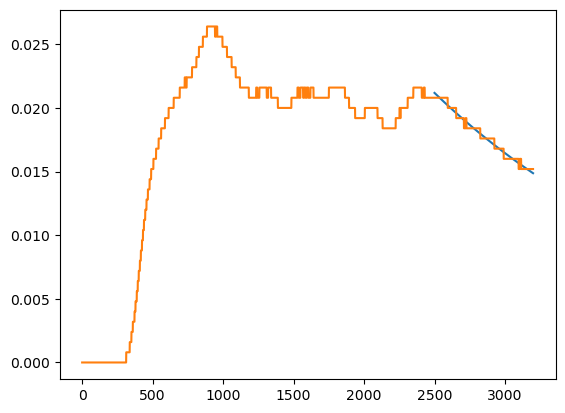

In [3]:
from scipy.optimize import curve_fit

def expon(t, b, a):
    return np.exp(-(t-a)/b)

t = np.arange(0, 700)
popt, pcov = curve_fit(expon, t, si2[ev][6500:7200], p0 = [10000, 10000])
plt.plot(t+2500, expon(t, *popt))
plt.plot(si2[ev][4000:7200], label = "SiPM 1 Hit Nr " + str(ev))
print(popt)
plt.show()

In [4]:
si2_tf = si2[ev]

def trapezoidal(i_d, K, L, M):
    si2_1 = np.roll(i_d, K)
    si2_1[0:K] = 0
    si2_2 = np.roll(i_d, L)
    si2_2[0:L] = 0
    si2_3 = np.roll(i_d, K+L)
    si2_3[0:K+L] = 0
    a = i_d - si2_1 - si2_2 + si2_3
    c = M * a
    d = np.array([0])
    for i in range(1, len(a)):
        d = np.append(d, a[i] + d[i-1])
    e = c + d
    f = np.array([0])
    for i in range(1, len(e)):
        f = np.append(f, e[i] + f[i-1])
  #  print(np.shape(f))
  #  print(np.shape(i_d))
    return f

def trapezoidal_depr(i_d, K, L, M):
    si2_temp = np.roll(i_d, K)
    si2_temp[0:K] = 0
    a = i_d - si2_temp
    a_temp = np.roll(a, L)
    a[0:L] = 0
    b = a - a_temp
    c = M * b
    d = np.array([0])
    for i in range(1, len(b)):
        d = np.append(d, b[i] + d[i-1])
    e = c + d
    f = np.array([0])
    for i in range(1, len(e)):
        f = np.append(f, e[i] + f[i-1])
   # print(np.shape(f))
   # print(np.shape(i_d))
    return int(f) / L / M
#si2[ev]

/usr/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


-60.5013888824589
(3, 400)


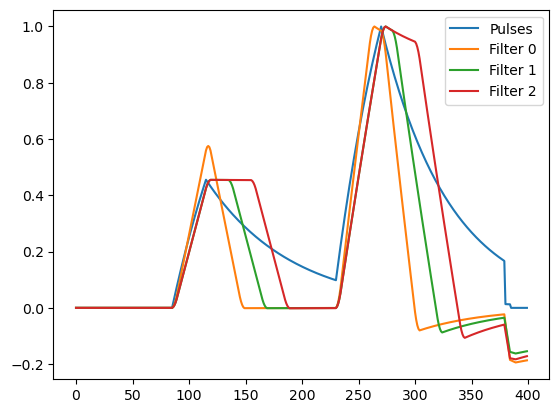

In [5]:
def sim_pulse(t, xin, a, b, c):
    
    x = a * np.exp(-(t-xin)/b) * np.heaviside(t-xin, 1)
    y = np.array([np.mean(x[int(i-c/2):int(i+c/2)]) for i in range(len(x))])
    y[:int(c/2)] = 0
    y[-int(c/2):] = 0
    return y

tbase = np.arange(0, 400)
pulses = sim_pulse(tbase, 100, 3, 75, 30) + sim_pulse(tbase, 250, 7, 60, 40)
pulses_f = trapezoidal(pulses, 30, 70, 1 / (np.exp(-1/60)-1))/1000
print(1 / (np.exp(-1/60)-1))
pulses_f2 = np.array([])
pulses_f2 = np.vstack((trapezoidal(pulses, 5, 30, 75), trapezoidal(pulses, 5, 50, 75),  trapezoidal(pulses, 5, 70, 75)))
print(np.shape(pulses_f2))

plt.plot(tbase, pulses/np.max(np.abs(pulses)), label = "Pulses")
#plt.plot(tbase, pulses_f/np.max(np.abs(pulses_f)))
for i in range(len(pulses_f2)):
    plt.plot(tbase, pulses_f2[i]/np.max(np.abs(pulses_f2[i])), label = "Filter " + str(i))
plt.legend()
plt.show()

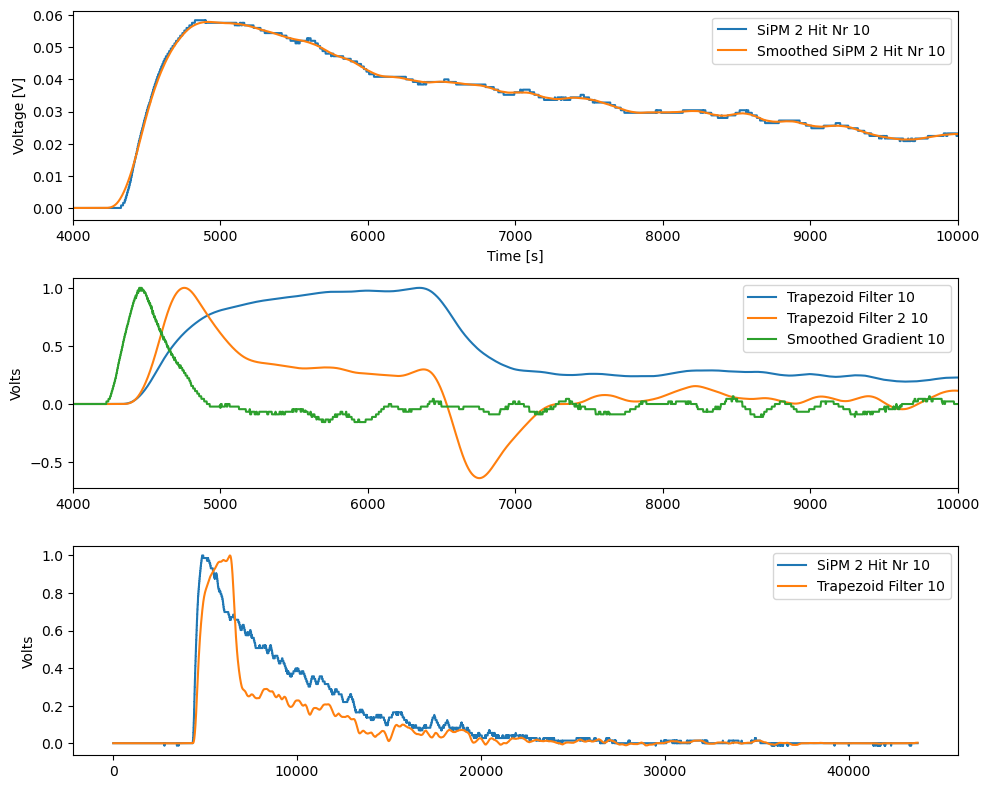

In [6]:
ev = 10
test = np.array([np.mean(si2[ev][i-100:i+100]) for i in range(len(si2[ev]))])
test[0:100] = 0
test[-100:0] = 0
K = 200
L = 2000
M = 1 / (np.exp(1/1976)-1)

f = trapezoidal(si2[ev], K, L, M)
g = trapezoidal(f, 50, 250, M)
plt.figure(figsize = (10, 8))
plt.subplot(311)
plt.plot(si2[ev], label = "SiPM 2 Hit Nr " + str(ev))
plt.plot(test, label = "Smoothed SiPM 2 Hit Nr " + str(ev))
plt.xlim(4000, 10000)
plt.ylabel("Voltage [V]")
plt.xlabel("Time [s]")
plt.legend()
plt.subplot(312)
plt.plot(f/np.max(np.abs(f)), label = "Trapezoid Filter " + str(ev))
plt.plot(g/np.max(np.abs(g)), label = "Trapezoid Filter 2 " + str(ev))
plt.plot(np.gradient(test)/np.max(np.abs(np.gradient(test))), label = "Smoothed Gradient " + str(ev))
plt.xlim(4000, 10000)
plt.ylabel("Volts")
plt.legend()
plt.subplot(313)
plt.plot(si2[ev]/np.max(np.abs(si2[ev])), label = "SiPM 2 Hit Nr " + str(ev))
plt.plot(f/np.max(np.abs(f)), label = "Trapezoid Filter " + str(ev))
#plt.xlim(4000, 10000)
plt.ylabel("Volts")
plt.legend()
plt.tight_layout()
plt.show()

## Apply Deconvolution Filter here

1


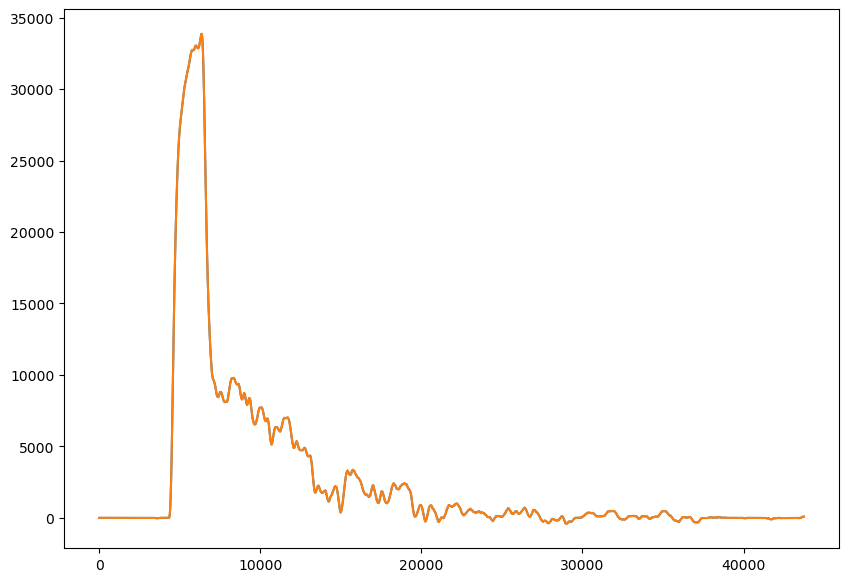

In [15]:
import sipm_filters as flt

Ts = np.abs(tbase[0]-tbase[1])
print(Ts)
t0 = 230e-9
tRC = 1e-6

plt.figure(figsize = (10, 7))
plt.plot(f)
plt.plot(flt.deconv(f, Ts, t0, tRC))
plt.show()